# Método de Newton aplicado à função geofísica (MUDAR PARA O MARQUADT)

O método de Newton é um método de gradiente aceitável, o qual expande a função objetivo em série de Taylor até segunda ordem em torno de $\mathbf{p}_i$:

\begin{equation}
\phi(\mathbf{p}) = \phi(\mathbf{p}_i) + \mathbf{J}_i^T(\mathbf{p} - \mathbf{p}_i) + \frac{1}{2}(\mathbf{p} - \mathbf{p}_i)^T\mathbf{H}_i(\mathbf{p} - \mathbf{p}_i)
\end{equation}

nde $\mathbf{J} = \boldsymbol{\nabla}_{\mathbf{p}}\phi |_{\mathbf{p} =\mathbf{p}_i}$ e $\mathbf{H} = \boldsymbol{\nabla}_{\mathbf{p}}\boldsymbol{\nabla}_{\mathbf{p}}^T\phi|_{\mathbf{p} =\mathbf{p}_i}$ .

Todo método de gradiente aceitável é definido pela equação:

\begin{equation}
\mathbf{p}_{i+1} = \mathbf{p}_i - \rho_i \mathbf{R}_i\mathbf{J}_i
\end{equation}

No método de Newton $\rho_i = 1$ e $\mathbf{R}_i = \mathbf{H}^{-1}_i$. Seu algoritmo fica:

1) estabelece um chute inicial $\mathbf{p}_i$

2) calcula $\mathbf{J}_i$ e $\mathbf{H}_i$

3) calcula $\mathbf{p}_{i+1} = \mathbf{p}_i - \mathbf{H}_i^{-1} \mathbf{J}_i$
 
4) testa a convergência, se for satisfeita o algoritmo para, caso contrário retorna para 1)

# Importando pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from visual import histeq
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.vis import mpl, myv

import sys
sys.path.insert(0, '../magnetic-radial-inversion/code')

import mag_polyprism_functions as mfun

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


# Modelagem direta

In [2]:
with open('data/cylinder_model.pickle') as w:
        cylinder_model = pickle.load(w)
with open('data/cylinder_data.pickle') as w:
        cylinder_data = pickle.load(w)
with open('data/regular_grid.pickle') as w:
        regular_grid = pickle.load(w)

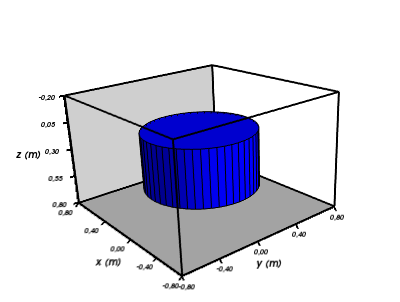

In [3]:
img(filename='bolacha.png')

## Plotando a função

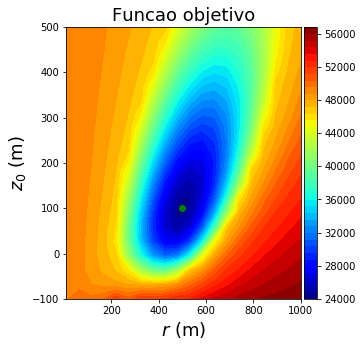

In [4]:
plt.figure(figsize=(5,5))
plt.plot(500., 100., 'og')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], cylinder_data['phi_eq'], 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.savefig('plot_geo_prob.png', pad_inches=0.0)
plt.show()

# Funções

In [5]:
def derivative_tf_z0(xp, yp, zp, prism, M, deltaz, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of one fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    delta: float - increment in x coordinate in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - deltaa
    prism_plus[0].z1 += deltaz
    prism_minus[0].z1 -= deltaz

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltaz)

    return df

def derivative_tf_radiall(xp, yp, zp, prism, M, deltar, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of a fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in radial distance in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    ang = 2.*np.pi/M # angle between two vertices
    
    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - delta

    for i in range(M):
        deltax = deltar*np.cos(i*ang)
        deltay = deltar*np.sin(i*ang)
        prism_plus[0].x[i] += deltax
        prism_plus[0].y[i] += deltay
        prism_minus[0].x[i] -= deltax
        prism_minus[0].y[i] -= deltay

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltar)

    return df

# calculando jacobiana de phi
def jacobi_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec):
    '''
    Returns the sensitivity matrix for polygonal prisms using finite
    differences.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in meters for radial distance
    deltaz: float - increment in meters for depth
    inc: float - inclination of the local-geomagnetic field
    dec: declination of the local-geomagnetic field

    output

    G: 2D array - sensitivity matrix
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    G = np.zeros((xp.size, 2))

    G[:, 0] = derivative_tf_radiall(xp, yp, zp, prism[0], M, deltar, inc, dec)
    G[:, 1] = derivative_tf_z0(xp, yp, zp, prism[0], M, deltaz, inc, dec)

    return G

# Funções de regularização

In [6]:
def regularization(p0, mi0, mi1, mit):
    '''
    Returns the value, gradient and Hessian of the constraint function.
    
    input
    
    p0: 1D array - parameters vector
    mi0: float - zero order Tikhonov's regularization parameter
    mi1: float - one order smoothness regularization parameter
    mit: float - total variation regularization parameter
    
    output
    
    phi: float - value of constraint function
    grad: 1D array - gradient of constraint funtion
    H: 2D array - Hessian of constraint function
    '''
    H = mi0*np.identity(p0.size)
    grad = mi0*p0
    phi = np.dot(p0, grad)
    
    RTR = np.array([[1.,-1.], [-1.,1.]])
    H += mi1*RTR
    grad += mi1*np.dot(RTR, p0)
    phi += np.dot(p0, grad)
    
    return phi, grad, H

# Modelo interpretativo

In [7]:
# chute inicial
p01 = 600.
p02 = 200.

# incremento para as derivadas
deltar = 0.01*p01
deltaz = 0.01*p02

r = np.zeros(cylinder_model['M']) + p01 # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, p02, cylinder_model['dz'], cylinder_model['props']]]

In [8]:
prism0 = mfun.pol2cart(l, cylinder_model['M'], cylinder_model['L'])

d0 = polyprism.tf(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'],
                    prism0, cylinder_model['inc'], cylinder_model['dec'])

# vetor do chute inicial
p0 = np.array([p01,p02]) 

# parâmetros para o critério de Armijo
alfa = .01
lamb = 100.
epsilon = 0.0000001
mi0 = 0.00000001
mi1 = 0.0000001
mit = 0.

phi_reg, grad_reg, H_reg = regularization(p0, mi0, mi1,  mit)

# calculando o valor da função e do resíduo em p0
res0 = cylinder_data['data_noise'] - d0
phi0 = np.sum(res0*res0) + phi_reg

p1_list = [p01]
p2_list = [p02]
phi_list = [phi0]

itmax = 100
itmax_marq = 20
lamb = 0.1
dlamb = 10.

pmax = np.array([800., 300.])
pmin = np.array([100., 0.])

In [9]:
phi_reg = np.zeros_like(cylinder_data['p1'].ravel())
p_reg = np.zeros(2)
for i, (r, z) in enumerate(zip(cylinder_data['p1'].ravel(),cylinder_data['p2'].ravel())):
    p_reg[0] = r
    p_reg[1] = z
    phi_reg[i], grad_reg, H_reg = regularization(p_reg, mi0, mi1,  mit)

In [10]:
phi_reg_plot = histeq(phi_reg)
phi_reg_plot = phi_reg.reshape(20,20)

# Algoritmo Levenberg-Marquadt

In [11]:
for it in range(itmax):
    # calculando os elementos da regularização
    phi_reg, grad_reg, H_reg = regularization(p0, mi0, mi1, mit)
    # calculando a Jacobiana e o gradiente
    G = jacobi_geo(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'], prism0, cylinder_model['M'],
                   deltar, deltaz, cylinder_model['inc'], cylinder_model['dec'])
    H = 2.*np.dot(G.T, G) + H_reg
    grad = -2.*np.dot(G.T, res0) + grad_reg
    
    pt0 = -np.log((pmax - p0)/(p0 - pmin))
    
    T = ((pmax - p0)*(p0 - pmin))/(pmax - pmin)*np.identity(2)
    
    for it_marq in range(itmax_marq):
        #print grad
        # calculando p e atualizando para a próxima iteração
        pt = pt0 + np.linalg.solve(np.dot(H,T) + lamb*np.identity(p0.size), -grad)
        #print p, p0
        p = pmin + (pmax - pmin)/(1. + np.exp(-pt))
        l = [[np.zeros(cylinder_model['M']) + p[0], x0, y0, p[1], cylinder_model['dz'], cylinder_model['props']]]
        prism = mfun.pol2cart(l, cylinder_model['M'], cylinder_model['L'])
        d = polyprism.tf(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'],
                        prism, cylinder_model['inc'], cylinder_model['dec'])
        res = cylinder_data['data_noise'] - d
        phi = np.sum(res*res) + phi_reg

        if (phi-phi0 > 0.):
            lamb *= dlamb
        else:
            lamb /= dlamb
            break
    
    if (abs(phi-phi0)/phi0 <= epsilon):
        break
    else:
        # armazenando os resultados em listas para o plot
        phi_list.append(phi)
        p1_list.append(p[0])
        p2_list.append(p[1])
        
        # atualizando parâmetros
        p0 = p.copy()
        d0 = d.copy()
        res0 = res.copy()
        phi0 = phi.copy()
        prism0 = prism
        
        # printa os valores
        print 'itreação: %3d   lambda: %.e   r: %.2f   z: %.2f   misfit: %.2e' % (it, lamb, p0[0], p0[1], phi0)

itreação:   0   lambda: 1e-02   r: 447.57   z: 67.06   misfit: 2.00e+02
itreação:   1   lambda: 1e-03   r: 510.49   z: 93.03   misfit: 3.89e+01
itreação:   2   lambda: 1e-04   r: 515.79   z: 85.82   misfit: 2.94e+01
itreação:   3   lambda: 1e-05   r: 515.69   z: 85.91   misfit: 2.94e+01
itreação:   4   lambda: 1e-06   r: 515.69   z: 85.91   misfit: 2.94e+01


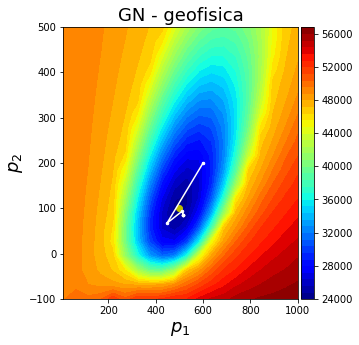

In [12]:
#plot
plt.figure(figsize=(5,5))
plt.plot(500., 100., 'oy')
plt.plot(p1_list, p2_list, '.w-', markersize=5)
plt.title('GN - geofisica', fontsize=18)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], cylinder_data['phi_eq'], 40, cmap='jet')
plt.xlabel('$p_1$', fontsize=18)
plt.ylabel('$p_2$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.savefig('plot_LM_geofisica.png', pad_inches=0.0)
plt.show()

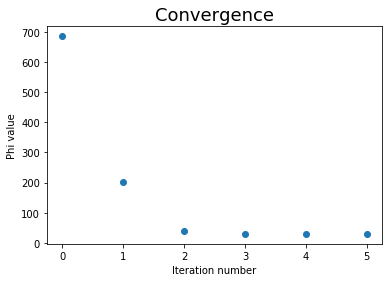

In [13]:
plt.title('Convergence', fontsize = 18)
plt.xlabel('Iteration number')
plt.ylabel('Phi value')
plt.plot(phi_list, 'o')
plt.savefig('convergence_LM_geofisca.png', dpi=300)
plt.show()

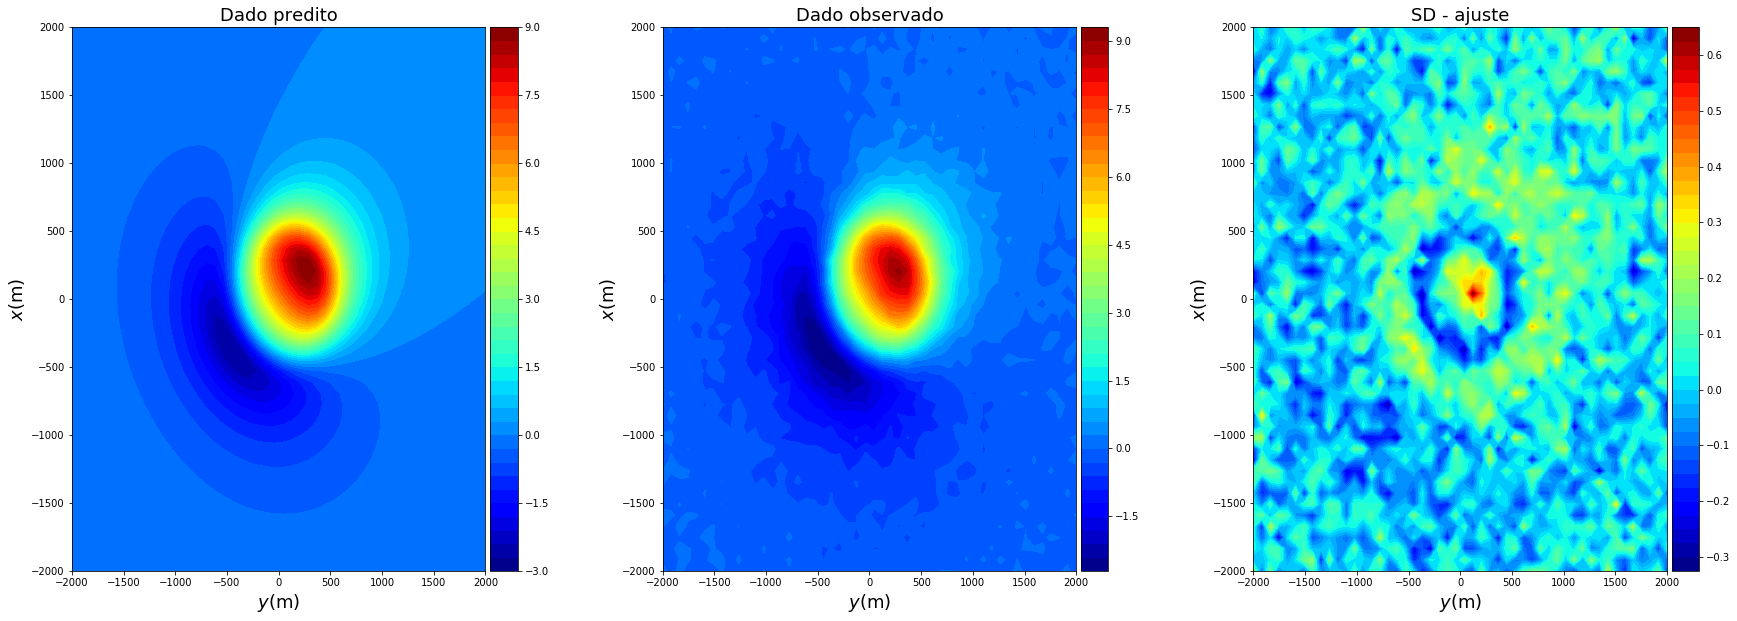

In [14]:
res = res.reshape(regular_grid['shape'])
xp = regular_grid['xp'].reshape(regular_grid['shape'])
yp = regular_grid['yp'].reshape(regular_grid['shape'])
dpred = cylinder_data['data'].reshape(regular_grid['shape'])
dobs = cylinder_data['data_noise'].reshape(regular_grid['shape'])

# plot
plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=18)
plt.contourf(yp, xp, dpred, 40, cmap='jet')
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=18)
plt.contourf(yp, xp, dobs, 40, cmap='jet')
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)

plt.subplot(1, 3, 3)
plt.title('SD - ajuste', fontsize=18)
plt.contourf(yp, xp, res, 40, cmap='jet')
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.savefig('plot_LM_ajuste.png', pad_inches=0.0)
plt.show()

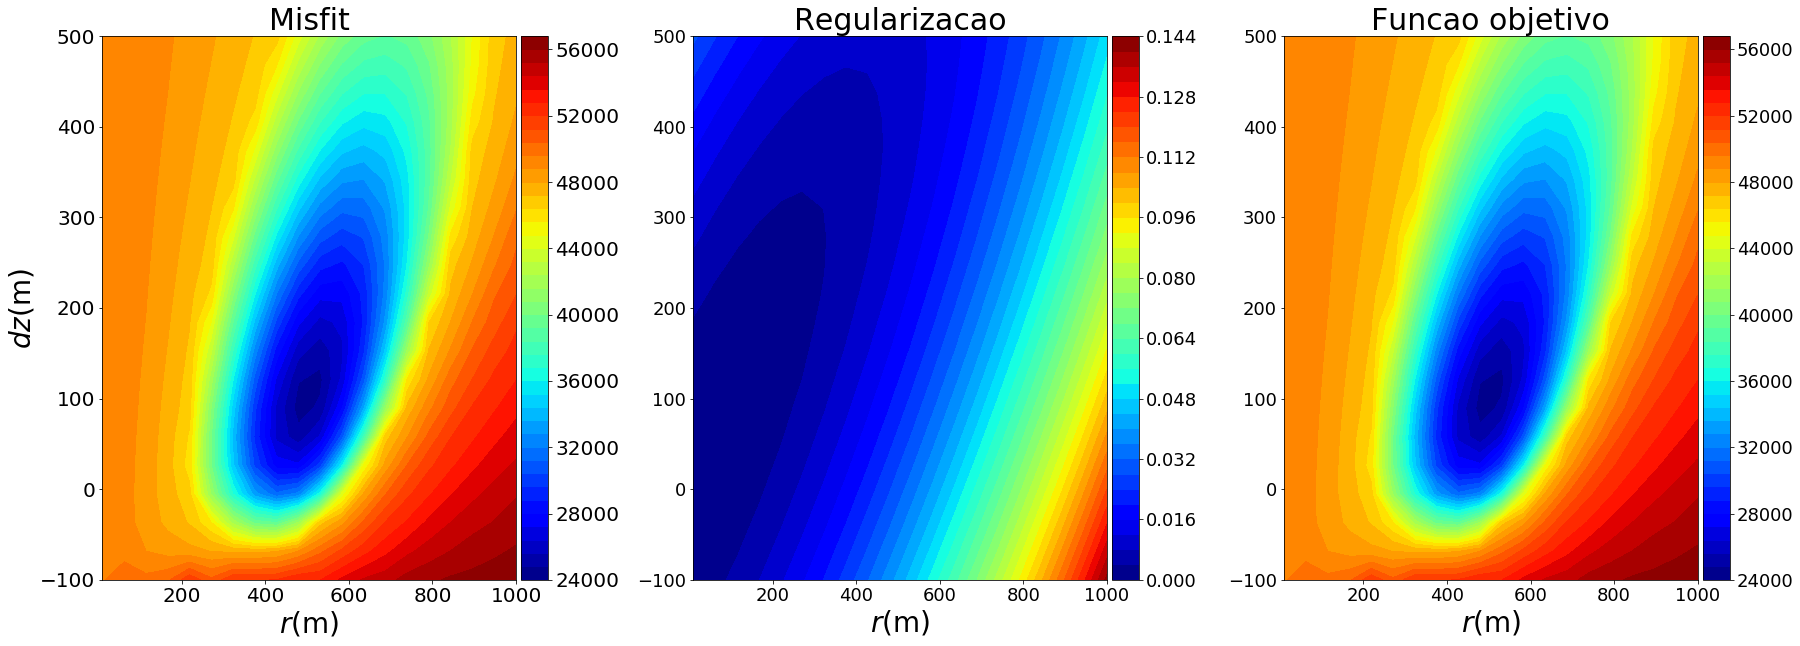

In [15]:
# plot
plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
plt.title('Misfit', fontsize=30)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], cylinder_data['phi_eq'], 40, cmap='jet').ax.tick_params(labelsize=20)
plt.xlabel('$r$(m)', fontsize=28)
plt.ylabel('$dz$(m)', fontsize=28)
plt.colorbar(pad=0.01, aspect=20, shrink=1).ax.tick_params(labelsize=20)

plt.subplot(1, 3, 2)
plt.title('Regularizacao', fontsize=30)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], phi_reg_plot, 40, cmap='jet').ax.tick_params(labelsize=18)
plt.xlabel('$r$(m)', fontsize=28)
#plt.ylabel('$x$(m)', fontsize=28)
plt.colorbar(pad=0.01, aspect=20, shrink=1).ax.tick_params(labelsize=18)

plt.subplot(1, 3, 3)
plt.title('Funcao objetivo', fontsize=30)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], cylinder_data['phi_eq']+phi_reg_plot, 40, cmap='jet').ax.tick_params(labelsize=18)
plt.xlabel('$r$(m)', fontsize=28)
#plt.ylabel('$x$(m)', fontsize=28)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=18)
plt.show()